# Lung analysis

In [2]:
%load_ext watermark
%watermark -v -m  -u -n -p pandas,numpy,matplotlib,seaborn,hsbmpy,topicpy -a Filippo_Valle -g -r -b -w

Filippo_Valle 
last updated: Mon Aug 10 2020 

CPython 3.8.5
IPython 7.17.0

pandas 1.1.0
numpy 1.19.1
matplotlib 3.2.2
seaborn 0.10.1
hsbmpy not installed
topicpy 1.1.3

compiler   : GCC 7.5.0
system     : Linux
release    : 4.19.76-linuxkit
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit
Git hash   : 9bb9e1f7b267a76e9e5b242d75e1271fde012ffc
Git repo   : git@github.com:fvalle1/cancers
Git branch : develop
watermark 2.0.2


In [3]:
# import libraries
import pandas as pd
import numpy as np
import sys, gc, os

We download *Discordant_Lusc* as described by [Papaleo et al.](https://bmccancer.biomedcentral.com/articles/10.1186/s12885-019-5965-x)

In [3]:
df_discordant = pd.read_csv("https://raw.githubusercontent.com/ELELAB/LUAD_LUSC_TCGA_comparison/master/6-recount/LUSC/discordant_samples.txt", header=None)
df_tcgabiolinks = pd.read_csv("../TCGA_biolinks.csv", index_col=0).dropna(how="all", axis=1)
df_tcgabiolinks = df_tcgabiolinks[df_tcgabiolinks["cancer.type"].isin(["LUAD","LUSC"])].set_index("pan.samplesID")
df_tcgabiolinks.head(2)

,cancer.type,Subtype_mRNA,Subtype_DNAmeth,Subtype_protein,Subtype_miRNA,Subtype_CNA,Subtype_Integrative,Subtype_other,Subtype_Selected
pan.samplesID,,,,,,,,,
TCGA-05-4249,LUAD,NaN,NaN,NaN,NaN,NaN,5,NaN,LUAD.5
TCGA-05-4382,LUAD,NaN,NaN,NaN,NaN,NaN,6,NaN,LUAD.6


We read a file *files_tcga.dat* obtained trough **gdc** API

In [4]:
df_files=pd.read_csv("files_tcga.dat", index_col=0)
df_files=df_files.drop_duplicates("cases.0.submitter_id")
df_files.sort_values('cases.0.submitter_id', inplace=True)

df_files=df_files[df_files['cases.0.submitter_id'].isin(df_tcgabiolinks.index)]

We append and merge the file from TCGA (gdc API) and the one from TCGA-Biolinks ([subtypes](https://bioconductor.org/packages/release/bioc/vignettes/TCGAbiolinks/inst/doc/subtypes.html))

In [5]:
df_files = df_files.reset_index().set_index('cases.0.submitter_id')
df_files = df_files.transpose().append(df_tcgabiolinks.reindex(index=df_files.index).transpose()).transpose()

We annotate Discordant_LUSC samples in the original dataset

In [6]:
for (sample,case) in zip(df_files.index,df_files["cases.0.samples.0.portions.0.analytes.0.aliquots.0.submitter_id"]):
    if case in df_discordant.values.ravel():
        df_files.at[sample,"cancer.type"]="Discordant_LUSC"

In [7]:
#df_files.dropna(how="any", axis=1, thresh=len(df_files.index)/25, inplace=True)
df_files.reset_index().set_index("file_name").fillna("unknown").to_csv("files.dat", index=True)

## Table of RNA-Seq data
We got and prepare the data using [Table_Creation.ipynb](Table_Creation.ipynb) and [TCGA_GetManifest.ipynb](TCGA_GetManifest.ipynb)

*mainfest.txt* files are available in this repository

In [8]:
df_files=df_files.fillna("unknown").set_index("file_name")
df_files.to_csv("files.dat", index=True, header=True)

In [10]:
df = pd.read_csv("mainTable_all.csv",index_col=0)

We ensure that all columns have a metadata antry in *df_files*

In [11]:
df = df.reindex(columns=df.columns[df.columns.isin(df_files.index)])
df.to_csv("mainTable.csv", index=True, header=True)
df_files.fillna("unknown").to_csv("files.dat", index=True)

We import *scanpy* to select **highly variable genes**

In [12]:
import scanpy as sc

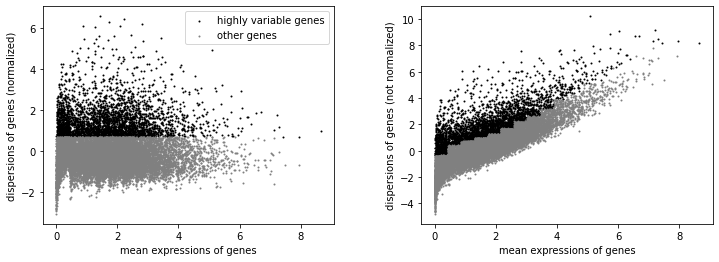

In [13]:
adata = sc.AnnData(X=df.transpose(), obs=df_files.reindex(index=df.columns))
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=3000)
sc.pl.highly_variable_genes(adata)
hvg = adata.var[adata.var["highly_variable"]==True].index

In [14]:
# save the table with HVG
df.reindex(index=hvg).to_csv("mainTable.csv", index=True, header=True)

### We can finally run hierarchical Stochastic Block Model
We run [stochastic block model](https://github.com/martingerlach/hSBM_Topicmodel/tree/develop).

Clone the repository with the code and add it to the system path

```bash
git clone --branch develop https://github.com/martingerlach/hSBM_Topicmodel/
```

Note: [graph-tool](https://graph-tool.skewed.de/) should be installed and correctly configured

In [11]:
!git clone --branch develop https://github.com/martingerlach/hSBM_Topicmodel/
sys.path.append("hSBM_Topicmodel")

Cloning into 'hSBM_Topicmodel'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 260 (delta 4), reused 5 (delta 0), pack-reused 248
Receiving objects: 100% (260/260), 3.61 MiB | 3.04 MiB/s, done.
Resolving deltas: 100% (60/60), done.


In [ ]:
from sbmtm import sbmtm

In [ ]:
hsbm = sbmtm()

In [ ]:
hsbm.make_graph_from_BoW_df(df.reindex(index=hvg))

In [ ]:
hsbm.save_graph("graph_hv.xml.gz")

In [ ]:
del hsbm
gc.collect()

# Stages

We perform afterwards *Survival analysis*

In [ ]:
#This notebook is intended to be run on a docker container which images derives from jupyter/datascience-notebook
sys.path.append(os.getcwd()+"/../")

#some helpful functions
from topicpy.hsbmpy import get_file, get_next_color
import matplotlib.pyplot as plt
import seaborn as sns
import os

We run these analyses on unified dataset, if want to run only on TCGA change the following cell

In [ ]:
#os.chdir("../lung")
os.chdir("../unified_lung")

In [ ]:
l=1
algorithm = "topsbm"
df_topics = pd.read_csv("%s/%s_level_%d_topic-dist.csv"%(algorithm,algorithm,l))
df_files = pd.read_csv("files.dat", index_col=0).dropna(how='all', axis=0)
df_topics.set_index('doc', inplace=True)
df_topics.insert(0,'stage','')
df_topics.insert(0,'type','')
df_topics.drop('i_doc', axis=1, inplace=True)
#labels = ["cases.0.diagnoses.0.tumor_stage","cancer.type"]
labels=["cases.0.diagnoses.0.tumor_stage","Type"]
label = labels[0]
if label not in df_files.columns:
    raise AttributeError(f"{label} not valid. Available: {df_files.columns}")
for letter in ["a", "b"]:
    for (old, new) in zip(["stage %s%s"%(i,letter) for i in ["i", "ii", "iii", "iv"]],["stage %s"%i for i in ["i", "ii", "iii", "iv"]]):
        df_files.replace(old, new, inplace=True)
for sample in df_topics.index.values:
    df_topics.at[sample,'stage']=("%s"%(get_file(sample,df_files)[labels[0]]))
    df_topics.at[sample,'type']=("%s"%(get_file(sample,df_files)[labels[1]]))

In [ ]:
mask = df_topics["stage"]!="not reported"
mask = (mask) & (df_topics["type"].isin(["LUAD", "LUSC"]))
mask = (mask) & (df_topics["stage"]!="nan")
#mask = np.ones(df_topics.shape[0],dtype=int)==1
df_topic_stage_gb = df_topics[mask].groupby(["type", "stage"])

In [ ]:
color_generator = get_next_color()
df_topic_stage = df_topics[mask]

for topic in df_topic_stage.columns[:4]:
    fig, axs = plt.subplots(1,2,figsize=(30,15))
    color = next(color_generator)
    for ((i,dataset), ax) in zip(enumerate(np.unique([idx for idx in df_topic_stage["type"] if ("Discordant" not in idx) and ("healthy") not in idx])), axs):
        
        df_topic_stage_dat = df_topic_stage[df_topic_stage["type"]==dataset].drop("type", axis=1)
        df_topic_stage_dat = df_topic_stage_dat.sort_values(["stage"])
        
        mask_stages = {}
        stages = df_topic_stage_dat["stage"].unique()
        for stage in stages:
            mask_stages[stage]= df_topic_stage_dat["stage"]==stage
        df_topic_stage_dat.drop("stage", axis=1, inplace=True)
            
        df_topic_stage_dat=df_topic_stage_dat.subtract(df_topic_stage_dat.mean(),1)
        data=np.array([df_topic_stage_dat[mask_stages[stage]].values for stage in stages])
        ax.boxplot(data, sym="o", flierprops={"c":"gray", "ms":20, "lw":5}, boxprops = {"lw":10}, whiskerprops={"lw":2}, capprops={"lw":5}, medianprops={"c":"red", "lw":10})
        
        labs = np.sort(df_topics[mask]["stage"].unique())
        ax.set_xticklabels(labels=labs, rotation=45)
        ax.set_xticks(np.linspace(1,len(labs)+1,len(labs)+1))
        ax.tick_params(labelsize=35)
        ax.set_title(dataset, fontsize=35)
        ax.set_xlabel("")
        
    axs[1].legend(fontsize=24, ncol=3)
    axs[0].set_ylabel("$<P(topic|stage)>$", fontsize=35)
    fig.savefig(f"topic_luad_lusc_{topic}.pdf")

    plt.show()

In [ ]:
color_generator = get_next_color()
df_topic_stage = df_topic_stage_gb.mean()

for topic in df_topic_stage.columns:
    fig, axs = plt.subplots(1,2,figsize=(30,15))
    color = next(color_generator)
    for ((i,dataset), ax) in zip(enumerate(np.unique([idx[0] for idx in df_topic_stage.index if ("Discordant" not in idx[0]) and ("healthy") not in idx[0]])), axs):
        idxs = int(round(df_topic_stage.index.shape[0]/2))
        idx = df_topic_stage.index[i*idxs:(i+1)*idxs]
        
        df_topic_stage_dat = df_topic_stage.reindex(index=idx, columns = [topic])
        mean = df_topic_stage_dat.mean(0).values[0]
        df_topic_stage_dat=df_topic_stage_dat.subtract(mean,1)
        #sigma = df_topic_stage_dat.std(0).values[0]
        #df_topic_stage_dat=df_topic_stage_dat.divide(sigma,1)
        df_topic_stage_dat.plot(ax=ax, marker="o",ms=55, lw=20, c=color, legend=False)
        
        x = ax.lines[0].get_xdata()
        y = ax.lines[0].get_ydata()
        err = (df_topic_stage_dat.std(0)).values.ravel()
        ax.fill_between(ax.lines[0].get_xdata(), y-err, y+err, color="gray", alpha=0.8)
        
        
        labs = np.sort(df_topics[mask]["stage"].unique())
        ax.set_xticklabels(labels=labs, rotation=45)
        ax.set_xticks(np.linspace(0,len(labs),len(labs)+1))
        ax.tick_params(labelsize=35)
        ax.set_title(dataset, fontsize=35)
        ax.set_xlabel("")
        
    axs[1].legend(fontsize=35, ncol=3)
    axs[0].set_ylabel("$<P(topic|stage)>$", fontsize=35)
    fig.savefig(f"topic_luad_lusc_{topic}.pdf")

    plt.show()

In [ ]:
topic = "Topic 3"
df_single_topic = pd.read_csv("%s/%s_level_%d_word-dist.csv"%(algorithm,algorithm,l), index_col=0).sort_values([topic], ascending=False)[topic].dropna()
for g in df_single_topic[df_single_topic>df_single_topic[df_single_topic>0].quantile(0.75)].index:
    print(g,df_single_topic.at[g])

In [ ]:
df_single_topic[df_single_topic>df_single_topic[df_single_topic>0].quantile(0.75)].to_csv("topic_3_lung.csv")

In [ ]:
import requests
with requests.get("https://david.ncifcrf.gov/data/download/conv_4D3189EEAD7F1588155942290.txt") as req:
    papaleo = [row.split("\t") for row in req.text.split("\n")]

In [ ]:
papaleo_ensg=list(zip(*papaleo[:-1]))[1][1:]

In [ ]:
np.array([g in papaleo_ensg for g in df_topics.values.ravel()]).any()

In [ ]:
rs = np.random.RandomState(42)

color_generator = get_next_color()
df_topic_stage = df_topic_stage_gb.mean()

df_topics_mc = df_topics.copy()

topic="Topic 3"
fig, axs = plt.subplots(1,2,figsize=(30,15))
color = next(color_generator)
for ((i,dataset), ax) in zip(enumerate(np.unique([idx[0] for idx in df_topic_stage.index if ("Discordant" not in idx[0]) and ("healthy") not in idx[0]])), axs):
    idxs = int(round(df_topic_stage.index.shape[0]/2))
    idx = df_topic_stage.index[i*idxs:(i+1)*idxs]

    df_topic_stage_dat = df_topic_stage.reindex(index=idx, columns = [topic])
    mean = df_topic_stage_dat.mean(0).values[0]
    df_topic_stage_dat=df_topic_stage_dat.subtract(mean,1)
    #sigma = df_topic_stage_dat.std(0).values[0]
    #df_topic_stage_dat=df_topic_stage_dat.divide(sigma,1)
    df_topic_stage_dat.plot(ax=ax, marker="o",ms=55, lw=20, c=color, legend=False)
    from sklearn.utils import shuffle
    
    errors = []
    for i in range(50):
        df_topics_mc["stage"] = shuffle(df_topics["stage"].values, random_state=rs)
        df_topics_mc_dat = df_topics_mc[mask].groupby(["type","stage"]).mean().reindex(index=idx, columns = [topic])
        df_topics_mc_dat = df_topics_mc_dat.subtract(df_topics_mc_dat.mean(0),1)
        errors.append(df_topics_mc_dat.values)
    
    x = ax.lines[0].get_xdata()
    y = ax.lines[0].get_ydata()
    err = np.std(np.array(errors), axis=0).ravel()
    ax.errorbar(ax.lines[0].get_xdata(), y, yerr=err, color="gray", alpha=0.8, elinewidth=15)
    
    labs = np.sort(df_topics[mask]["stage"].unique())
    ax.set_xticklabels(labels=labs, rotation=45)
    ax.set_xticks(np.linspace(0,len(labs),len(labs)+1))
    ax.tick_params(labelsize=35)
    ax.set_title(dataset, fontsize=35)
    ax.set_xlabel("")

axs[1].legend(fontsize=35, ncol=3)
axs[0].set_ylabel("$<P(topic|stage)>$", fontsize=35)

plt.show()

In [ ]:
rs = np.random.RandomState(42)

color_generator = get_next_color()
df_topic_stage = df_topic_stage_gb.mean()

df_topics_mc = df_topics.copy()

topic="Topic 3"
fig, axs = plt.subplots(1,2,figsize=(30,15))
color = next(color_generator)
for ((i,dataset), ax) in zip(enumerate(np.unique([idx[0] for idx in df_topic_stage.index if ("Discordant" not in idx[0]) and ("healthy") not in idx[0]])), axs):
    idxs = int(round(df_topic_stage.index.shape[0]/2))
    idx = df_topic_stage.index[i*idxs:(i+1)*idxs]

    df_topic_stage_dat = df_topic_stage.reindex(index=idx, columns = [topic])
    mean = df_topic_stage_dat.mean(0).values[0]
    df_topic_stage_dat=df_topic_stage_dat.subtract(mean,1)
    #sigma = df_topic_stage_dat.std(0).values[0]
    #df_topic_stage_dat=df_topic_stage_dat.divide(sigma,1)
    df_topic_stage_dat.plot(ax=ax, marker="o",ms=55, lw=20, c=color, legend=False)
    from sklearn.utils import shuffle
    
    def f(x,a,b):
        return a+b*x
    
    popts = []
    for i in range(4):
        x = np.arange(0,4)
        leave_out = x!=i
        popt, pcov = curve_fit(f, x[leave_out],df_topic_stage_dat.values.ravel()[leave_out])
        ax.plot(x, f(x, *popt), c="gray")
        popts.append(popt)
        
    ax.plot(x, f(x, *np.average(popts,0)), c="red")
        
    labs = np.sort(df_topics[mask]["stage"].unique())
    ax.set_xticklabels(labels=labs, rotation=45)
    ax.set_xticks(np.linspace(0,len(labs),len(labs)+1))
    ax.tick_params(labelsize=35)
    ax.set_title(dataset, fontsize=35)
    ax.set_xlabel("")

axs[1].legend(fontsize=35, ncol=3)
axs[0].set_ylabel("$<P(topic|stage)>$", fontsize=35)

plt.show()

# Overlap with Lucchetta et al.

In [6]:
import requests as req
from topicpy.converter import convert_list_to_ensg
papaleo_ensg = []
l0 = 0
for dataset in ["LUAD", "LUSC"]:
    for updown in ["up", "down"]:
        with req.get(f"https://raw.githubusercontent.com/ELELAB/LUAD_LUSC_TCGA_comparison/master/4-final_gene_list_DEA_TCGA/final_gene_list/new_{updown}_all_{dataset}.txt") as r:
            l = convert_list_to_ensg(r.text.split("\n"))
            l0 += len(l)
            for g in l:
                if (type(g)==str) and ("ENSG" in g):
                    papaleo_ensg.append(g)
papaleo_ensg=np.unique(np.array(papaleo_ensg).ravel())

In [7]:
df_topics = pd.read_csv("topsbm/topsbm_level_0_word-dist.csv", index_col=0)

list_1 = papaleo_ensg
list_2 = df_topics.index.values


from scipy.stats import hypergeom
x =  np.array([g in list_1 for g in list_2]).sum() # number of successes
M = 20000 # pop size
k = l0 # successes in pop
N = len(list_2) # sample size
pval = hypergeom.sf(x-1, M, k, N)
print(f"we have in common with Luccetta et al. {x}, assuming human has {M} genes, they analyse {k} genes in 4 sets up/down LUAD/LUSC, we filtered {N} genes, the chances this happen are P={pval}. The {round(x/k*100,2)}% of genes are in common")

we have in common with Luccetta et al. 633, assuming human has 20000 genes, they analyse 2953 genes in 4 sets up/down LUAD/LUSC, we filtered 3000 genes, the chances this happen are P=1.534603305139276e-24. The 21.44% of genes are in common
